# Geospatial Python
## Temporal assessment using command line arguments 
Setup: https://carpentries-incubator.github.io/geospatial-python/index.html

Based on instruction: https://carpentries-incubator.github.io/geospatial-python/09-raster-calculations.html

Boundary data source - https://burnseverity.cr.usgs.gov/ravg/data-access, searched for "cameron peak"

This notebook does the following:
- Loads a boundary file of a fire boundary
- Searches for satellite data within the area and during the growing season for a specific year
- Takes several of the retrieved satellite images and merges them together to get complete coverage
- Translates the satellite data into a value representing vegetative growth (Normalized Difference Vegetation Index, NDVI)
- Classifies and generates statisitics of the vegetative growth, saves the output as both text and geotiff 

We'll want to compare different years to see pre, post, and potentially other years of vegetative growth within a burn area.
To do this, we'll leverage a library called *papermill*(https://github.com/nteract/papermill) allowing us to pass parameters to the notebook which will dynamically load, analyze, and save our results for a specific year of satellite data.

When we deploy this script to a HPC environment, running mulitple instances of it will allow us to much more rapidly get our results.

Here's one call of this script for the year 2021:

```
papermill Boundary\ Raster\ Classification.ipynb output_2021.ipynb -p year 2021
```

In [1]:
import pystac
import geopandas as gpd
import folium # to make interactive maps
import rioxarray
from rioxarray import merge
from pystac_client import Client # to query STAC API endpoint

import geojson # to parse spatial data format
import folium # to create an interactive map
from folium.plugins import Draw # to allow drawing

# Create a variable to determine if the notebook is being run locally
local_run=False
if local_run:
    # this package is problematic on remote computers
    from localtileserver import TileClient, get_folium_tile_layer # to visualize the geotiff

import numpy as np # to work with numbered lists
import xarray # to preserve spatial metadata when working with numbered lists

import earthpy.plot as ep # for drawing a legend
import matplotlib.pyplot as plt # for plotting
from matplotlib.colors import ListedColormap # to color our classified data


In [2]:
# Start by setting a variable for the year
# THIS CODE CELL has the tag 'parameters' (see https://github.com/nteract/papermill)
# This tag will allow us to overwrite the contents of the cell using the command line, which also creates a new notebook
# We'll set a 'year' variable and look at the satellite image just before the fire broke out
# Note: The Cameron Peak fire occured August 13, 2020
year = 2020

In [3]:
# Load in our boundary data
boundary = gpd.read_file("data/co4060910587920200813_20180915_20210907_burn_bndy.zip")
boundary

,Event_ID,irwinID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,BurnBndLon,...,Perim_ID,dNBR_offst,dNBR_stdDv,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment,geometry
0,CO4060910587920200813,53741A13-D269-4CD5-AF91-02E094B944DA,CAMERON PEAK,Wildfire,10019755,RAVG,Extended,2439,40.527,-105.234,...,None,-3,28,0,0,92,156,230,None,"POLYGON ((-771811.757 1981074.506, -771814.499..."
1,CO4060910587920200813,53741A13-D269-4CD5-AF91-02E094B944DA,CAMERON PEAK,Wildfire,10019755,RAVG,Extended,206407,40.62,-105.558,...,None,-3,28,0,0,92,156,230,None,"MULTIPOLYGON (((-800256.471 2010330.829, -8002..."


In [4]:
# Show the data types
print(boundary.dtypes)

Event_ID              object
irwinID               object
Incid_Name            object
Incid_Type            object
Map_ID                 int64
Map_Prog              object
Asmnt_Type            object
BurnBndAc              int64
BurnBndLat            object
BurnBndLon            object
Ig_Date       datetime64[ms]
Pre_ID                object
Post_ID               object
Perim_ID              object
dNBR_offst             int64
dNBR_stdDv             int64
NoData_T               int64
IncGreen_T             int64
Low_T                  int64
Mod_T                  int64
High_T                 int64
Comment               object
geometry            geometry
dtype: object


In [5]:
# View the map file 'boundary'
# Use the file's lat and long column to center the map
m = folium.Map([boundary.iloc[1]['BurnBndLat'],boundary.iloc[1]['BurnBndLon']], zoom_start = 10)

# Change the column type for display on the interactive map 
boundary['Ig_Date'] = boundary['Ig_Date'].astype(str) # otherwise error "Object of type Timestamp is not JSON serializable"

# Add the layer to the map
folium.GeoJson(boundary).add_to(m)

# Show the map
m

In [6]:
# Display the boundary variable
boundary.boundary

0    LINESTRING (-771811.757 1981074.506, -771814.4...
1    MULTILINESTRING ((-800256.471 2010330.829, -80...
dtype: geometry

In [7]:
# Show the boundary CRS
boundary.crs

<Projected CRS: ESRI:102039>
Name: USA_Contiguous_Albers_Equal_Area_Conic_USGS_version
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
# Convert tne boundary to use CRS '4326'
boundary=boundary.to_crs("4326")

In [9]:
# Join the rows to get a complete bounds
poly=boundary.geometry.union_all()
poly.bounds

(-105.90369724996037,
 40.46133610013139,
 -105.19902122896542,
 40.77811826544475)

In [10]:
# Perform metadata search from Sentinel-2, Level 2A, to retrieve Cloud Optimized GeoTiffs (COGs)
api_url = "https://earth-search.aws.element84.com/v1"

# Open the api
client = Client.open(api_url)
# Store a variable pointing to the collection of interest
# Note: collection ID is taken from Sentinel-2 Level 2A - https://radiantearth.github.io/stac-browser/#/external/earth-search.aws.element84.com/v1/collections/sentinel-2-c1-l2a
collection = "sentinel-2-l2a" 

search = client.search(
    collections=[collection],
    bbox=poly.bounds,# https://datatracker.ietf.org/doc/html/rfc7946#section-5
    datetime=str(year)+"-07-01/"+str(year)+"-07-31",
    query=["eo:cloud_cover<20"],
    limit=10
)
# Show the number of scenes (i.e. the portion of the footage recorded by the satellite)
print(search.matched())

8


In [11]:
# Sort the items by cloud_cover
items = search.item_collection()

items_sorted = sorted(items, key=lambda x: x.properties["eo:cloud_cover"]) 

In [12]:
# Lets short list the items which we'll merge later and then clip
# Start by gathering the hrefs
red_item_hrefs=[]
nir_item_hrefs=[]

for i in items_sorted[0:3]:
    print(i)
    red_item_hrefs.append(i.assets["red"].href)
    nir_item_hrefs.append(i.assets["nir08"].href)

<Item id=S2B_13TDE_20200710_1_L2A>
<Item id=S2B_13TDF_20200710_1_L2A>
<Item id=S2B_13TDF_20200710_0_L2A>


In [13]:
# View the map file 'boundary'
# Use the file's lat and long column to center the map
m = folium.Map([boundary.iloc[1]['BurnBndLat'],boundary.iloc[1]['BurnBndLon']], zoom_start = 10)

# Add the boundary
folium.GeoJson(boundary).add_to(m)


# View the red band 'items' on the map
if local_run:
    for id, i in enumerate(red_item_hrefs):
        tiles = TileClient(i) # create tiles client
        tile_layer = get_folium_tile_layer(tiles, name='red_'+str(id)) # create tile layer
        tile_layer.add_to(m)
else:
    # We'll just show the raster boundaries
    # Some extra modules and a library are required for this
    from shapely.geometry import box # To create a box
    from shapely.ops import transform # The shapely transform module  
    import pyproj # A reprojection library
    # Create the transformer
    project = pyproj.Transformer.from_crs(rioxarray.open_rasterio(red_item_hrefs[0]).rio.crs.to_epsg(), 4326, always_xy=True).transform
    
    # Apply the transformation
    for id, i in enumerate(red_item_hrefs):
        raster = rioxarray.open_rasterio(red_item_hrefs[id])
        # Create boundary boxes
        bbox = box(*raster.rio.bounds())
        bbox_transformed = transform(project, bbox)
        folium.GeoJson(bbox_transformed,
            style_function=lambda feature: {
            "color": "purple",
        }).add_to(m)

# show the bounds of the file 'boundary'
folium.Rectangle(
    bounds=[[poly.bounds[1], poly.bounds[0]], [poly.bounds[3], poly.bounds[2]]],
).add_to(m)

draw = Draw(export=True)
draw.add_to(m)

folium.LayerControl().add_to(m)

# Show the map
m

In [14]:
# Open the rasters and store them in separate lists using the argument masked=True.

red_rasters=[]
for i in red_item_hrefs:
    red_rasters.append(rioxarray.open_rasterio(i, masked=True))

nir_rasters=[]
for i in nir_item_hrefs:
    nir_rasters.append(rioxarray.open_rasterio(i, masked=True))

In [15]:
# Set our boundry to the CRS of the raster
boundary_new_crs=boundary.to_crs(red_rasters[0].rio.crs)
poly_new_crs=boundary_new_crs.geometry.union_all()

# Show the bounds
poly_new_crs.bounds

(423505.4568095259, 4479028.868030736, 483137.79665757786, 4514313.830211404)

In [16]:
# Merge our files into one

red_merged = merge.merge_arrays(red_rasters,poly_new_crs.bounds)

nir_merged = merge.merge_arrays(nir_rasters,poly_new_crs.bounds)

In [17]:
# Export the two merged files. Add the 'year' variable as part of the file name

red_merged.rio.to_raster("red_merged"+str(year)+".tif")

nir_merged.rio.to_raster("nir_merged"+str(year)+".tif")

## Raster Math

## Crop raster data with polygons

In [18]:
# Check the shapes of the two rasters
print(red_merged.shape, nir_merged.shape)

(1, 3528, 5963) (1, 1764, 2982)


In [19]:
# As their width and height do not match, 
# use reproject_match to both reproject and clip the raster to the CRS.
red_merged_matched = red_merged.rio.reproject_match(nir_merged,nodata=np.nan ) # Set NaN as NoData
print(red_merged_matched.shape)

(1, 1764, 2982)


In [20]:
# Compute the NDVI as a new raster 
ndvi = (nir_merged - red_merged_matched)/ (nir_merged + red_merged_matched)
print(ndvi)

<xarray.DataArray (band: 1, y: 1764, x: 2982)> Size: 21MB
array([[[ 0.6086747 ,  0.61491317,  0.5894577 , ...,  0.25682482,
          0.3167109 ,         nan],
        [ 0.56617296,  0.55731225,  0.611729  , ...,  0.24807233,
          0.2450614 ,         nan],
        [ 0.5390782 ,  0.54212093,  0.57990867, ...,  0.27789935,
          0.29206437,         nan],
        ...,
        [ 0.12268041,  0.18157294,  0.1727008 , ...,  0.4090139 ,
          0.3153046 ,         nan],
        [ 0.10787626, -0.21702352,  0.01604841, ...,  0.40944636,
          0.35015956,         nan],
        [ 0.1658574 ,  0.06980656, -0.21713442, ...,  0.29220268,
          0.2551724 ,         nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 24kB 4.235e+05 4.235e+05 ... 4.831e+05 4.831e+05
  * y            (y) float64 14kB 4.514e+06 4.514e+06 ... 4.479e+06 4.479e+06
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0


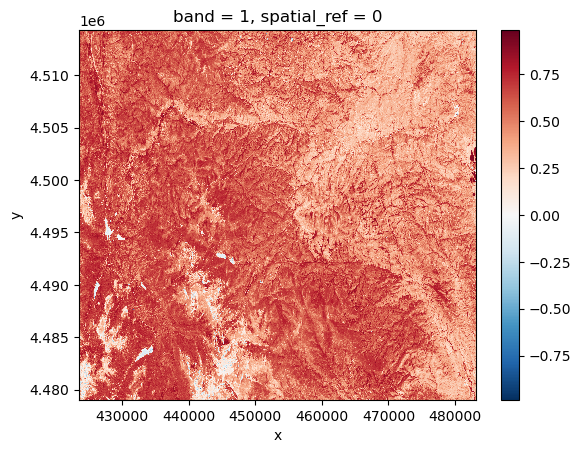

In [21]:
# Plot the outputted NDVI
ndvi.plot()

(array([9.00000e+00, 3.00000e+00, 1.00000e+00, 0.00000e+00, 3.00000e+00,
        5.00000e+00, 9.00000e+00, 3.00000e+00, 6.00000e+00, 2.00000e+01,
        2.70000e+01, 2.30000e+01, 4.80000e+01, 7.10000e+01, 1.04000e+02,
        2.42000e+02, 4.50000e+02, 8.86000e+02, 1.39800e+03, 2.07200e+03,
        2.70300e+03, 3.94400e+03, 6.15400e+03, 8.47200e+03, 6.97100e+03,
        6.87200e+03, 9.69800e+03, 1.49590e+04, 2.20240e+04, 3.49190e+04,
        6.72220e+04, 1.45003e+05, 2.45354e+05, 3.07640e+05, 3.28151e+05,
        3.35087e+05, 3.38903e+05, 3.53005e+05, 3.81997e+05, 4.21185e+05,
        4.56797e+05, 4.87763e+05, 4.90653e+05, 4.03353e+05, 2.21889e+05,
        1.00259e+05, 3.99890e+04, 1.04850e+04, 1.64800e+03, 5.00000e+00]),
 array([-0.98518521, -0.94606465, -0.90694416, -0.8678236 , -0.82870305,
        -0.78958249, -0.750462  , -0.71134144, -0.67222089, -0.63310039,
        -0.59397984, -0.55485928, -0.51573879, -0.47661823, -0.43749768,
        -0.39837715, -0.35925663, -0.32013607, -0

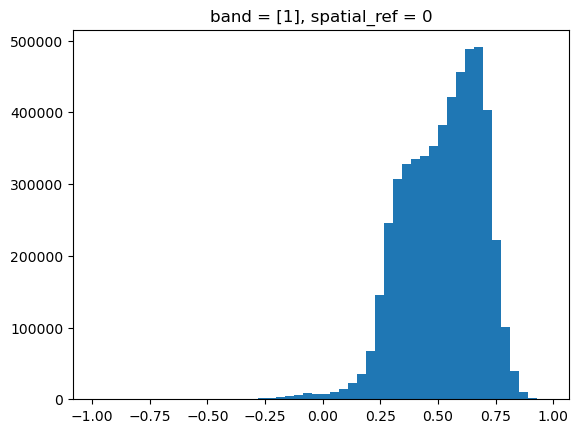

In [22]:
# Plot a histogram to see the spread of values accross 50 bins
ndvi.plot.hist(bins=50)

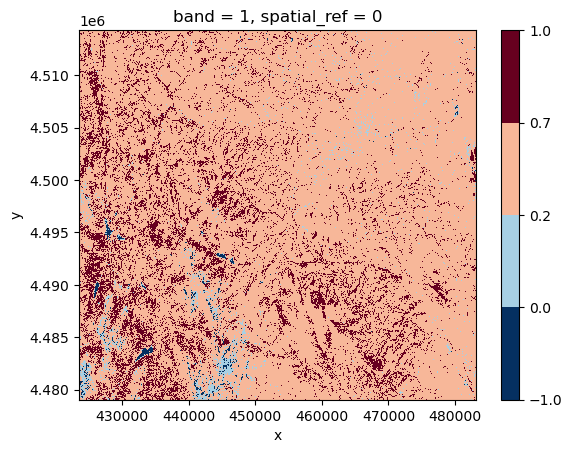

In [23]:
# Discretize the color plot by specifying the intervals
class_bins = (-1, 0., 0.2, 0.7, 1)
ndvi.plot(levels=class_bins)

In [24]:
# Missing values can be interpolated from the values of neighbouring grid cells using the .interpolate_na method. 
ndvi_nonan = ndvi.interpolate_na(dim="x")

# Save the output with the 'year' variable as part of the file name
ndvi_nonan.rio.to_raster("NDVI"+str(year)+".tif")

## Classifying Continuous Rasters in Python

Reduce the complexity of the map by classifying it. 

Classification involves assigning each pixel in the raster to a class based on its value. 

In Python, we can accomplish this using the *numpy.digitize* function

Note: by default, each class includes the left but not the right bound. This is not an issue here, since the computed range of NDVI values is fully contained in the open interval (-1; 1) (see exercise above).

In [25]:
import numpy as np
import xarray

# Defines the bins for pixel values
class_bins = (-1, 0., 0.2, 0.7, 1)

# The numpy.digitize function returns an unlabeled array, in this case, a
# classified array without any metadata. That doesn't work--we need the
# coordinates and other spatial metadata. We can get around this by using
# "xarray.apply_ufunc", which can run the function across the data array while
# preserving metadata.
ndvi_classified = xarray.apply_ufunc(
    np.digitize,
    ndvi_nonan,
    class_bins,
    dataset_fill_value=np.nan
)

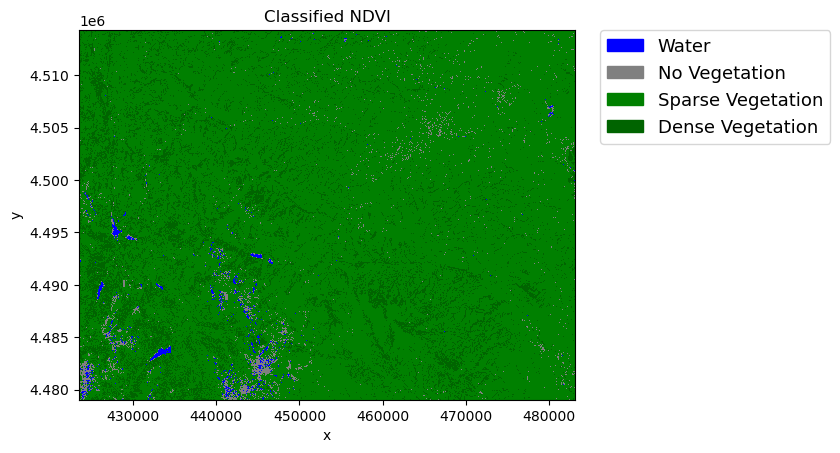

In [26]:
# Visualize the classified NDVI, customizing the plot with proper title and legend
import earthpy.plot as ep
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

# Define color map of the map legend
ndvi_colors = ["blue", "gray", "green", "darkgreen"]
ndvi_cmap = ListedColormap(ndvi_colors)

# Define class names for the legend
category_names = [
    "Water",
    "No Vegetation",
    "Sparse Vegetation",
    "Dense Vegetation"
]

# We need to know in what order the legend items should be arranged
category_indices = list(range(len(category_names)))

# Make the plot
im = ndvi_classified.plot(cmap=ndvi_cmap, add_colorbar=False)
plt.title("Classified NDVI")
# earthpy helps us by drawing a legend given an existing image plot and legend items, plus indices
ep.draw_legend(im_ax=im, classes=category_indices, titles=category_names)

# Save the figure (optional)
# plt.savefig("NDVI_classified.png", bbox_inches="tight", dpi=300)

In [27]:
# Export the classified NDVI raster object to a GeoTiff
ndvi_classified.rio.to_raster("NDVI"+str(year)+"_classified.tif", dtype="int32")

(array([3.479700e+04, 0.000000e+00, 1.022450e+05, 0.000000e+00,
        0.000000e+00, 4.379947e+06, 0.000000e+00, 7.414950e+05,
        0.000000e+00, 1.764000e+03]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

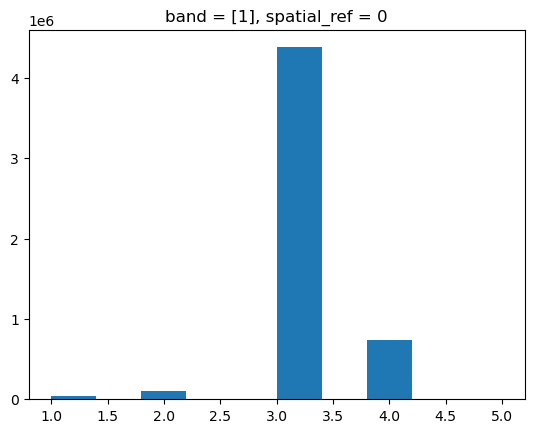

In [28]:
# Plot a histogram of the classified data
ndvi_classified.plot.hist()

In [29]:
# Load both raster datasets: NDVI.tif and NDVI_classified.tif. 
# Then, calculate zonal statistics for each class_bins. Inspect the output of the zonal_stats function.

from xrspatial import zonal_stats
stats=zonal_stats(ndvi_classified.squeeze(), ndvi.squeeze())
stats

,zone,mean,max,min,sum,std,var,count
0,1,-0.113437,-0.000085,-0.985185,-3.947253e+03,0.091015,0.008284,34797.0
1,2,0.134327,0.199897,0.000000,1.373424e+04,0.052495,0.002756,102245.0
2,3,0.495707,0.700000,0.200000,2.171172e+06,0.132621,0.017588,4379947.0
3,4,0.746606,0.970842,0.700022,5.536048e+05,0.038533,0.001485,741495.0
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Output counts to a csv file

# First check if this file exists
file_path = "output.csv"
try: 
    with open(file_path, 'x') as file: 
        file.write("year,"+",".join(category_names)+ "\n") 
except FileExistsError: 
    pass

# Append to the existing file
with open(file_path, 'a') as file: 
    file.write(str(year)+","+",".join(str(x) for x in stats["count"])+ "\n") 